## Importing Libraries

In [90]:
import numpy as np
from PIL import Image
from collections import namedtuple
import os
import glob
import pickle
import time
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from typing import *

## Extracting Haar Features 

In [2]:
Feature = namedtuple('Feature', 'name x y width height coords_x coords_y coeffs')

## Two rectangles placed vertically 
def feature2v(x, y, width, height):
    coords_x = [x, x+width, x, x+width,
                x, x+width, x, x+width]
    coords_y = [y, y, y+height, y+height,
                y+height, y+height, y+2*height, y+2*height]
    coeffs = [1, -1, -1, 1,
              -1, 1, 1, -1]
    return Feature('Two Vertical Features', x, y, width, 2*height, coords_x, coords_y, coeffs)


## Three rectangles placed vertically 
def feature3v(x, y, width, height):
    coords_x = [x, x+width, x, x+width,
                x, x+width, x, x+width,
                x, x+width, x, x+width]
    coords_y = [y, y, y+height, y+height,
                y+height, y+height, y+2*height, y+2*height,
                y+2*height, y+2*height, y+3*height, y+3*height]
    coeffs = [-1, 1, 1, -1,
               1, -1, -1, 1,
              -1, 1, 1, -1]
    return Feature('Three Vertical', x, y, width, 3*height, coords_x, coords_y, coeffs)

## Two rectangles placed horizontally 
def feature2h(x, y, width, height):
    coords_x = [x, x+width, x, x+width,
                x+width, x+2*width, x+width, x+2*width]
    coords_y = [y, y, y+height, y+height,
               y, y, y+height, y+height]
    coeffs = [-1, 1, 1, -1,
             1, -1, -1, 1]
    return Feature('Two Horizontal Features', x, y, 2*width, height, coords_x, coords_y, coeffs)



## Three rectangles placed horizontally 
def feature3h(x, y, width, height):
    coords_x = [x, x+width, x, x+width,
                x+width, x+2*width, x+width, x+2*width,
                x+2*width, x+3*width, x+2*width, x+3*width]
    coords_y = [y, y, y+height, y+height,
                y, y, y+height, y+height,
                y, y, y+height, y+height]
    coeffs = [-1, 1, 1, -1,
               1, -1, -1, 1,
              -1, 1, 1, -1]
    return Feature('Three Horizontal Features', x, y, 3*width, height, coords_x, coords_y, coeffs)


## Four rectangles placed diagonally 
def feature4d(x, y, width, height):
    coords_x = [x, x+width, x, x+width,
                x+width, x+2*width, x+width, x+2*width,
                x, x+width, x, x+width,
                x+width, x+2*width, x+width, x+2*width]
    coords_y = [y, y, y+height, y+height,
                y, y, y+height, y+height,
                y+height, y+height, y+2*height, y+2*height,
                y+height, y+height, y+2*height, y+2*height]
    coeffs = [-1, 1, 1, -1,
               1, -1, -1, 1,
               1, -1, -1, 1,
              -1, 1, 1, -1]
    return Feature('Four Diagonal Features', x, y, 2*width, 2*height, coords_x, coords_y, coeffs)


In [3]:
def compute_feature(image, feature):
    return np.sum(np.multiply(image[feature.coords_y, feature.coords_x], feature.coeffs))

In [4]:
## Calculating integral image
def calculate_integral_image(array):
    s = np.zeros(array.shape)
    ii = np.zeros(array.shape)
    for x in range(array.shape[0]):
        for y in range(0,array.shape[1]):
            s[x,y] = s[x,y-1] + array[x,y] if y>0 else array[x,y]
            ii[x,y] = ii[x-1,y] + s[x,y] if x>0 else s[x,y]
    return np.pad(ii, (1, 1), 'constant', constant_values=(0, 0))[:-1, :-1]

In [5]:
###### Finding shapes and positions of different haar features
def find_features(image_shape):
        height, width = image_shape
        features = [[],[],[],[],[]]
        names = ['Two Vertical Features', 'Two Horizontal Features', 'Three Vertical Features', 'Three Horizontal Features', 'Four Diagonal Features']
        for i in range(width):
            for j in range(height):
                for w in range(1, width+1):
                    for h in range(1, height+1):
                        if i + w < width and j + h < height:
                            if j + 2 * h < height:
                                features[0].append(feature2v(i, j, w, h))
                            if i + 2 * w < width: 
                                features[1].append(feature2h(i, j, w, h))
                            if j + 3 * h < height: 
                                features[2].append(feature3v(i, j, w, h))

                            if i + 3 * w < width:
                                features[3].append(feature3h(i, j, w, h))
                            
                            if i + 2 * w < width and j + 2 * h < height:
                                features[4].append(feature4d(i, j, w, h))
        total_features = []
        for i,fn in enumerate(names):
            print('Feature %s with value: %d' % (names[i], len(features[i])))
            total_features.extend(features[i])
        print('Total Number of Features', len(total_features))
        return total_features

In [6]:
input_image = Image.open('Dataset/trainset/faces/face00001.png')
input_integral = calculate_integral_image( np.array(input_image))
total_features = find_features(input_integral.shape)

Feature Two Vertical Features with value: 17100
Feature Two Horizontal Features with value: 17100
Feature Three Vertical Features with value: 10830
Feature Three Horizontal Features with value: 10830
Feature Four Diagonal Features with value: 8100
Total Number of Features 63960


## Build your Adaboost Detector 

### Extracting the train and test files which is of shape (Number of features * number of images in test/train)

In [7]:
def image_to_array(img):
    return np.array(img)
def array_to_image(values):
    return Image.fromarray(values)

In [54]:
train_X = []
train_Y = []

faces_directory = "Dataset/trainset/faces/"
face_files = glob.glob(os.path.join(faces_directory, '*.png'))
print('Number of Training face files is:',len(face_files))


non_faces_directory = "Dataset/trainset/non-faces/"
non_faces_files = glob.glob(os.path.join(non_faces_directory, '*.png'))
print('Number of Training non-face files is:',len(non_faces_files))


for f in face_files:
    data_x = image_to_array(Image.open(f))
    data_integral= calculate_integral_image(data_x)
        # compute all feature values for this image
    feature_values = []
    for f in total_features:
        feature_values.append(compute_feature(data_integral, f))
    train_X.append(feature_values)
    train_Y.append(1.0)
        
for f in non_faces_files:
    data_x = image_to_array(Image.open(f))
    data_integral= calculate_integral_image(data_x)
        # compute all feature values for this image
    feature_values = []
    for f in total_features:
        feature_values.append(compute_feature(data_integral, f))
    train_X.append(feature_values)
    train_Y.append(0.0)
        
train_X = np.array(train_X)
train_Y = np.array(train_Y)
print('Train samples feature value matrix shape is',train_X.shape)
train_X.dump('data_train-X')
train_Y.dump('data_train-Y')

test_X = []
test_Y = []

faces_test_directory = "Dataset/testset/faces/"
face_test_files = glob.glob(os.path.join(faces_test_directory, '*.png'))
print('Number of Testing face files is:',len(face_test_files))

non_faces_test_directory = "Dataset/testset/non-faces/"
non_faces_test_files = glob.glob(os.path.join(non_faces_test_directory, '*.png'))
print('Number of Testing non-face files is:',len(non_faces_test_files))


for f in face_test_files:
    data_x = image_to_array(Image.open(f))
    data_integral= calculate_integral_image(data_x)
        # compute all feature values for this image
    feature_values = []
    for f in total_features:
        feature_values.append(compute_feature(data_integral, f))
    test_X.append(feature_values)
    test_Y.append(1.0)
        
for f in non_faces_test_files:
    data_x = image_to_array(Image.open(f))
    data_integral= calculate_integral_image(data_x)
        # compute all feature values for this image
    feature_values = []
    for f in total_features:
        feature_values.append(compute_feature(data_integral, f))
    test_X.append(feature_values)
    test_Y.append(0.0)
        
test_X = np.array(test_X)
test_Y = np.array(test_Y)
print('Test samples feature value matrix shape is',test_X.shape)
test_X.dump('data_test-X')
test_Y.dump('data_test-Y')

Number of Training face files is: 499
Number of Training non-face files is: 2000
Train samples feature value matrix shape is (2499, 63960)
Number of Testing face files is: 472
Number of Testing non-face files is: 2001
Test samples feature value matrix shape is (2473, 63960)


In [8]:
ClassifierResult = namedtuple('ClassifierResult', 'feature position polarity threshold classification_error')
WeakClassifier = namedtuple('WeakClassifier', 'polarity threshold alpha classifier position')

In [9]:
train_X = pickle.load( open( "data_train-X", "rb" ) )
train_Y = pickle.load( open( "data_train-Y", "rb" ) )
test_X = pickle.load( open( "data_test-X", "rb" ) )
test_Y = pickle.load( open( "data_test-Y", "rb" ) )

In [10]:
print(train_X.shape, train_Y.shape)

(2499, 63960) (2499,)


In [11]:
print(test_X.shape, test_Y.shape)

(2473, 63960) (2473,)


In [12]:
def adaboostTrain(train_X, train_Y, T, features, weights =None):
    if weights is None:
        faces = len(train_Y[train_Y > 0.5])
        non_faces = len(train_Y[train_Y < 0.5])

        weights = np.zeros(train_Y.shape)
        weights[train_Y > 0.5] = 1.0/(2*faces)
        weights[train_Y < 0.5] = 1.0/(2*non_faces)

    weak_classifiers = []
    for t in range(T):
        start_time = time.time()
        print('Weak classifier Round',t+1)
        weights = weights / weights.sum()
        # best weak classifier for this round
        best = ClassifierResult(feature=None, position=0, polarity=0, threshold=0, classification_error=float('inf'))
        processed = 1
        print('Completed: ')
        for i,f in enumerate(features):
            result = apply_feature(f, i, train_X[:,i], train_Y, weights)
            if result.classification_error < best.classification_error:
                    best = result
            processed += 1
            if processed % 5000 == 0:
                print(processed, end=' ')
        beta = best.classification_error / (1 - best.classification_error)
        alpha = np.log(1. / beta)
        classifier = WeakClassifier(threshold=best.threshold, polarity=best.polarity, classifier=best.feature, position=best.position, alpha=alpha)
        for i, (fx, y) in enumerate(zip(train_X[:,classifier.position], train_Y)):
            h = weak_classifier(fx, classifier.polarity, classifier.threshold)
            e = np.abs(h - y)
            weights[i] = weights[i] * np.power(beta, 1-e)
            
        weak_classifiers.append(classifier)
        time_now = time.time()
        print('Time taken', (time_now - start_time))
    return weak_classifiers

In [13]:
def apply_feature(feature, position, train_fX, train_Y, weights):
    threshold, polarity = determine_threshold_polarity(train_fX, train_Y, weights)
    # Determine the classification error
    error = 0.0
    for fx, y, w in zip(train_fX, train_Y, weights):
        h = weak_classifier(fx, polarity, threshold)
        error += w * np.abs(h - y)
            
    return ClassifierResult(threshold=threshold, polarity=polarity, 
                            classification_error=error, feature=feature, position=position)

In [14]:
def determine_threshold_polarity(data_y, weights, feature_val) :  
    index = np.argsort(feature_val)
    feature_val= feature_val[index]
    data_y= data_y[index]
    weights= weights[index]
    total_minus, total_plus, running_minuses, running_pluses = calculate_running_sum(data_y, weights)
    return best_feature_threshold(feature_val, total_minus, total_plus, running_minuses, running_pluses)

In [15]:
def best_feature_threshold(feature_val, total_minus, total_plus, running_minuses, running_pluses):
    min_thresh, polarity = 0, 0
    min_e = float('inf')
    for thres, e_m, e_p in zip(feature_val, running_minuses, running_pluses):
        error_p = e_p + (total_minus - e_m)
        error_m = e_m + (total_plus - e_p)
        if error_p < min_e:
            min_e = error_p
            polarity = -1
            min_thresh = thres

        elif error_m < min_e:
            min_e = error_m
            polarity = 1
            min_thresh = thres

    return min_thresh, polarity

In [16]:
def calculate_running_sum(data_y, weights):
    running_minus, running_plus = 0.0, 0.0
    total_minus, total_plus = 0.0, 0.0
    running_minuses,  running_pluses = [], []
    for output, weight in zip(data_y, weights):
        if output > 0.5:
            running_plus += weight
            total_plus += weight
        else:
            running_minus += weight
            total_minus += weight
        running_minuses.append(running_minus)
        running_pluses.append(running_plus)
    return total_minus, total_plus, running_minuses, running_pluses

In [17]:
def weak_classifier(fx, polarity, threshold):
    ## as per definition of weak classifier
    if(polarity * fx) < (polarity*threshold): 
        return 1
    return 0

## Training for different rounds 

In [30]:
print('Training Started')
weak_classifiers_t1 = adaboostTrain(train_X, train_Y, 1, total_features)
with open('weak_classifiers_t1.pkl', 'wb') as f:
        pickle.dump(weak_classifiers_t1, f)

Training Started
Weak classifier Round 1
Completed: 
5000 10000 15000 20000 25000 30000 
Time taken 302.6230311393738


In [32]:
print(weak_classifiers_t1)

[WeakClassifier(polarity=-1, threshold=0.00025, alpha=1.2165390200872, classifier=Feature(name='Two Horizontal Features', x=7, y=6, width=12, height=10, coords_x=[7, 13, 7, 13, 13, 19, 13, 19], coords_y=[6, 6, 16, 16, 6, 6, 16, 16], coeffs=[-1, 1, 1, -1, 1, -1, -1, 1]), position=28028)]


In [33]:
print('Training Started')
weak_classifiers_t3 = adaboostTrain(train_X, train_Y, 3, total_features)
with open('weak_classifiers_t3.pkl', 'wb') as f:
        pickle.dump(weak_classifiers_t3, f)

Training Started
Weak classifier Round 1
Completed: 
5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 
Time taken 612.2144219875336
Weak classifier Round 2
Completed: 
5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 
Time taken 1219.707447052002
Weak classifier Round 3
Completed: 
5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 
Time taken 1820.9375336170197


In [34]:
print(weak_classifiers_t3)

[WeakClassifier(polarity=-1, threshold=0.00025, alpha=1.2165390200872, classifier=Feature(name='Two Horizontal Features', x=7, y=6, width=12, height=10, coords_x=[7, 13, 7, 13, 13, 19, 13, 19], coords_y=[6, 6, 16, 16, 6, 6, 16, 16], coeffs=[-1, 1, 1, -1, 1, -1, -1, 1]), position=28028), WeakClassifier(polarity=1, threshold=0.0006494257128421341, alpha=0.9550542896694941, classifier=Feature(name='Two Vertical Features', x=5, y=14, width=2, height=4, coords_x=[5, 7, 5, 7, 5, 7, 5, 7], coords_y=[14, 14, 16, 16, 16, 16, 18, 18], coeffs=[1, -1, -1, 1, -1, 1, 1, -1]), position=8829), WeakClassifier(polarity=-1, threshold=0.0015178189805250537, alpha=0.8468125295076987, classifier=Feature(name='Three Horizontal Features', x=5, y=2, width=9, height=1, coords_x=[5, 8, 5, 8, 8, 11, 8, 11, 11, 14, 11, 14], coords_y=[2, 2, 3, 3, 2, 2, 3, 3, 2, 2, 3, 3], coeffs=[-1, 1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1]), position=50342)]


In [35]:
print('Training Started')
weak_classifiers_t5 = adaboostTrain(train_X, train_Y, 5, total_features)
with open('weak_classifiers_t5.pkl', 'wb') as f:
        pickle.dump(weak_classifiers_t5, f)

Training Started
Weak classifier Round 1
Completed: 
5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 
Time taken 604.4594006538391
Weak classifier Round 2
Completed: 
5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 
Time taken 1202.868344783783
Weak classifier Round 3
Completed: 
5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 
Time taken 1793.9267752170563
Weak classifier Round 4
Completed: 
5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 
Time taken 2381.163828611374
Weak classifier Round 5
Completed: 
5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 
Time taken 2966.9337134361267


In [36]:
print(weak_classifiers_t5)

[WeakClassifier(polarity=-1, threshold=0.00025, alpha=1.2165390200872, classifier=Feature(name='Two Horizontal Features', x=7, y=6, width=12, height=10, coords_x=[7, 13, 7, 13, 13, 19, 13, 19], coords_y=[6, 6, 16, 16, 6, 6, 16, 16], coeffs=[-1, 1, 1, -1, 1, -1, -1, 1]), position=28028), WeakClassifier(polarity=1, threshold=0.0006494257128421341, alpha=0.9550542896694941, classifier=Feature(name='Two Vertical Features', x=5, y=14, width=2, height=4, coords_x=[5, 7, 5, 7, 5, 7, 5, 7], coords_y=[14, 14, 16, 16, 16, 16, 18, 18], coeffs=[1, -1, -1, 1, -1, 1, 1, -1]), position=8829), WeakClassifier(polarity=-1, threshold=0.0015178189805250537, alpha=0.8468125295076987, classifier=Feature(name='Three Horizontal Features', x=5, y=2, width=9, height=1, coords_x=[5, 8, 5, 8, 8, 11, 8, 11, 11, 14, 11, 14], coords_y=[2, 2, 3, 3, 2, 2, 3, 3, 2, 2, 3, 3], coeffs=[-1, 1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1]), position=50342), WeakClassifier(polarity=1, threshold=8.014742134524864e-05, alpha=0.975410190

In [37]:
print('Training Started')
weak_classifiers_t10 = adaboostTrain(train_X, train_Y, 10, total_features)
with open('weak_classifiers_t10.pkl', 'wb') as f:
        pickle.dump(weak_classifiers_t10, f)

Training Started
Weak classifier Round 1
Completed: 
5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 
Time taken 604.5669097900391
Weak classifier Round 2
Completed: 
5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 
Time taken 1198.9835255146027
Weak classifier Round 3
Completed: 
5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 
Time taken 1789.7440819740295
Weak classifier Round 4
Completed: 
5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 
Time taken 2378.2077338695526
Weak classifier Round 5
Completed: 
5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 
Time taken 2965.0958666801453
Weak classifier Round 6
Completed: 
5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 
Time taken 3548.5311064720154
Weak classifier Round 7
Completed: 
5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 
Time taken 4133.637430429459
Weak classifier Rou

In [39]:
print(weak_classifiers_t10)

[WeakClassifier(polarity=-1, threshold=0.00025, alpha=1.2165390200872, classifier=Feature(name='Two Horizontal Features', x=7, y=6, width=12, height=10, coords_x=[7, 13, 7, 13, 13, 19, 13, 19], coords_y=[6, 6, 16, 16, 6, 6, 16, 16], coeffs=[-1, 1, 1, -1, 1, -1, -1, 1]), position=28028), WeakClassifier(polarity=1, threshold=0.0006494257128421341, alpha=0.9550542896694941, classifier=Feature(name='Two Vertical Features', x=5, y=14, width=2, height=4, coords_x=[5, 7, 5, 7, 5, 7, 5, 7], coords_y=[14, 14, 16, 16, 16, 16, 18, 18], coeffs=[1, -1, -1, 1, -1, 1, 1, -1]), position=8829), WeakClassifier(polarity=-1, threshold=0.0015178189805250537, alpha=0.8468125295076987, classifier=Feature(name='Three Horizontal Features', x=5, y=2, width=9, height=1, coords_x=[5, 8, 5, 8, 8, 11, 8, 11, 11, 14, 11, 14], coords_y=[2, 2, 3, 3, 2, 2, 3, 3, 2, 2, 3, 3], coeffs=[-1, 1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1]), position=50342), WeakClassifier(polarity=1, threshold=8.014742134524864e-05, alpha=0.975410190

In [15]:
print('Training Started')
weak_classifiers_t25 = adaboostTrain(train_X, train_Y, 25, total_features)
with open('weak_classifiers_t25.pkl', 'wb') as f:
        pickle.dump(weak_classifiers_t25, f)

Training Started
Weak classifier Round 1
Completed: 
5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 
Time taken 443.47032737731934
Weak classifier Round 2
Completed: 
5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 
Time taken 886.9323117733002
Weak classifier Round 3
Completed: 
5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 
Time taken 1330.3267273902893
Weak classifier Round 4
Completed: 
5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 
Time taken 1774.1792905330658
Weak classifier Round 5
Completed: 
5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 
Time taken 2220.7268681526184
Weak classifier Round 6
Completed: 
5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 
Time taken 2670.2051949501038
Weak classifier Round 7
Completed: 
5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 
Time taken 3119.742525100708
Weak classifier Rou

In [32]:
print('Training Started')
weak_classifiers_t50 = adaboostTrain(train_X, train_Y, 50, total_features)
with open('weak_classifiers_t50.pkl', 'wb') as f:
        pickle.dump(weak_classifiers_t50, f)

Training Started
Weak classifier Round 1
Completed: 
5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 Time taken 440.28538393974304
Weak classifier Round 2
Completed: 
5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 Time taken 442.8167188167572
Weak classifier Round 3
Completed: 
5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 Time taken 456.19665145874023
Weak classifier Round 4
Completed: 
5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 Time taken 456.1645886898041
Weak classifier Round 5
Completed: 
5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 Time taken 456.3518624305725
Weak classifier Round 6
Completed: 
5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 Time taken 458.61493945121765
Weak classifier Round 7
Completed: 
5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 Time taken 460.10176396369934
Weak classifier Round 8
Com

## Calculating Performance for different rounds using Strong Classifier

In [42]:
def strong_classifier(x, weak_classifiers):
    lhs = 0.0
    rhs = 0.0
    for wc in weak_classifiers:
        lhs += wc.alpha * weak_classifier(x[wc.position], wc.polarity, wc.threshold)
        rhs += wc.alpha
    if lhs >= 0.5*rhs:  ## as per definition of strong classifier
        return 1
    else:
        return 0

In [24]:
test_X = pickle.load( open( "data_test-X", "rb" ) )
test_Y = pickle.load( open( "data_test-Y", "rb" ) )

In [40]:
def evaluate_performance(data_X, data_Y, weak_classifiers):
    y_predicted = []
    for x in data_X:
        y_predicted.append(strong_classifier(x, weak_classifiers))
    return performance(data_Y,y_predicted)

In [43]:
def performance(data_test_y, y_predicted):
    tn, fp, fn, tp = confusion_matrix(data_test_y, y_predicted).ravel()
    acc = accuracy_score(data_test_y, y_predicted)
    fpr = fp/(fp+tn)
    fnr = fn/(tp+fn)
    return acc, fpr, fnr

In [24]:
for t in [1,3,5,10]:
    print('Performance for round: ',t)
    op = pickle.load( open( "weak_classifiers_t"+str(t)+".pkl", "rb" ) )
    print('On train(ACC, FPR and FNR) :', evaluate_performance(train_X, train_Y, op))
    print('On test(ACC, FPR and FNR) :',evaluate_performance(test_X, test_Y, op))

Performance for round:  1
On train(ACC, FPR and FNR) : (0.6618647458983593, 0.411, 0.04609218436873747)
On test(ACC, FPR and FNR) : (0.4585523655479175, 0.5827086456771614, 0.3665254237288136)
Performance for round:  3
On train(ACC, FPR and FNR) : (0.8231292517006803, 0.173, 0.19238476953907815)
On test(ACC, FPR and FNR) : (0.6122118883946623, 0.2983508245877061, 0.7669491525423728)
Performance for round:  5
On train(ACC, FPR and FNR) : (0.8355342136854742, 0.1965, 0.036072144288577156)
On test(ACC, FPR and FNR) : (0.5818843509906996, 0.3373313343328336, 0.760593220338983)
Performance for round:  10
On train(ACC, FPR and FNR) : (0.9003601440576231, 0.124, 0.002004008016032064)
On test(ACC, FPR and FNR) : (0.7137080469065912, 0.17641179410294852, 0.7521186440677966)


## Drawing bounding box for different rounds

In [38]:
def image_display_2_horizontal(classify):
    test_image = "Dataset/testset/faces/cmu_0001.png"
    Image.open(test_image).resize((100,100))
    test_image_array = image_to_array(Image.open(test_image))
    x = classify.classifier.x
    y = classify.classifier.y
    width = classify.classifier.width
    height = classify.classifier.height
    test_image_array[y:y+height, x:x+width//2] = 255
    test_image_array[y:y+height, x+width//2:x+width] = 0
    return (array_to_image(test_image_array))

In [39]:
def image_display_2_vertical(classify):
    test_image = "Dataset/testset/faces/cmu_0001.png"
    Image.open(test_image).resize((100,100))
    test_image_array = image_to_array(Image.open(test_image))
    x = classify.classifier.x
    y = classify.classifier.y
    width = classify.classifier.width
    height = classify.classifier.height
    test_image_array[y:y+height//2, x:x+width] = 0
    test_image_array[y+height//2:y+height, x:x+width] = 255
    return (array_to_image(test_image_array))

In [40]:
def image_display_3_vertical(classify):
    test_image = "Dataset/testset/faces/cmu_0001.png"
    Image.open(test_image).resize((100,100))
    test_image_array = image_to_array(Image.open(test_image))
    x = classify.classifier.x
    y = classify.classifier.y
    width = classify.classifier.width
    height = classify.classifier.height
    test_image_array[y:y+height//3, x:x+width] = 255
    test_image_array[y+height//3:y+(2*height)//3, x:x+width] = 0
    test_image_array[y+(2*height)//3:y+height, x:x+width] = 255
    return (array_to_image(test_image_array))

In [52]:
def image_display_3_horizontal(classify):
    test_image = "Dataset/testset/faces/cmu_0001.png"
    Image.open(test_image).resize((100,100))
    test_image_array = image_to_array(Image.open(test_image))
    x = classify.classifier.x
    y = classify.classifier.y
    width = classify.classifier.width
    height = classify.classifier.height
    test_image_array[y:y+height, x:x+width//3] = 0
    test_image_array[y:y+height, x+width//3:x+(2*width)//3] = 255
    test_image_array[y:y+height, x+(2*width)//3:x+width] = 0
    return (array_to_image(test_image_array))

In [53]:
def image_display_4_diagonal(classify):
    test_image = "Dataset/testset/faces/cmu_0001.png"
    Image.open(test_image).resize((100,100))
    test_image_array = image_to_array(Image.open(test_image))
    x = classify.classifier.x
    y = classify.classifier.y
    width = classify.classifier.width
    height = classify.classifier.height
    test_image_array[y:y+height//2, x:x+width//2] = 255
    test_image_array[y:y+height//2, x+width//2:x+width] = 0
    test_image_array[y+height//2:y+height, x:x+width//2] = 0
    test_image_array[y+height//2:y+height, x+width//2:x+width] = 255
    return (array_to_image(test_image_array))

In [54]:
clf= pickle.load( open( "weak_classifiers_t10.pkl", "rb" ) )

In [55]:
for t in [1,3,5,10]:
    if clf[t-1].classifier.name =='Two Horizontal Features':
        image = image_display_2_horizontal(clf[t-1]).resize((200,200))
    elif clf[t-1].classifier.name =='Two Vertical Features':
        image =image_display_2_vertical(clf[t-1]).resize((200,200))
    elif clf[t-1].classifier.name =='Three Horizontal Features':
        image =image_display_3_horizontal(clf[t-1]).resize((200,200))
    elif clf[t-1].classifier.name =='Three Vertical Features':
        image =image_display_3_vertical(clf[t-1]).resize((200,200))
    elif clf[t-1].classifier.name =='Four Diagonal Features':
        image =image_display_4_diagonal(clf[t-1]).resize((200,200))
    image.save(str(t)+".png")


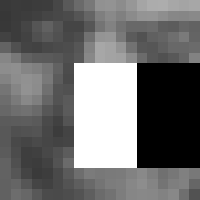

In [56]:
Image.open(str(1)+".png")

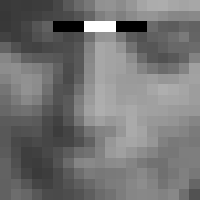

In [57]:
Image.open(str(3)+".png")

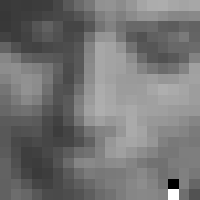

In [58]:
Image.open(str(5)+".png")

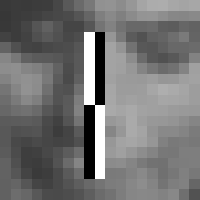

In [59]:
Image.open(str(10)+".png")

## Adjust the threshold

### A) Adjusting threshold for FNR

In [56]:
def adaboostTrainFN(train_X, train_Y, T, features, weights =None):
    if weights is None:
        faces = len(train_Y[train_Y > 0.5])
        non_faces = len(train_Y[train_Y < 0.5])

        weights = np.zeros(train_Y.shape)
        weights[train_Y > 0.5] = 1.0/(2*faces)
        weights[train_Y < 0.5] = 1.0/(2*non_faces)

    weak_classifiers = []
    for t in range(T):
        start_time = time.time()
        print('Weak classifier Round',t+1)
        weights = weights / weights.sum()
        # best weak classifier for this round
        best = ClassifierResult(feature=None, position=0, polarity=0, threshold=0, classification_error=float('inf'))
        processed = 1
        print('Completed: ')
        for i,f in enumerate(features):
            result = apply_feature_fn(f, i, train_X[:,i], train_Y, weights)
            if result.classification_error < best.classification_error:
                    best = result
            processed += 1
            if processed % 5000 == 0:
                print(processed, end=' ')
        beta = best.classification_error / (1 - best.classification_error)
        alpha = np.log(1. / beta)
        classifier = WeakClassifier(threshold=best.threshold, polarity=best.polarity, classifier=best.feature, position=best.position, alpha=alpha)
        for i, (fx, y) in enumerate(zip(train_X[:,classifier.position], train_Y)):
            h = weak_classifier(fx, classifier.polarity, classifier.threshold)
            e = np.abs(h - y)
            weights[i] = weights[i] * np.power(beta, 1-e)
            
        weak_classifiers.append(classifier)
        time_now = time.time()
        print('Time taken', (time_now - start_time))
    return weak_classifiers

In [57]:
def apply_feature_fn(feature, position, train_fX, train_Y, weights):
    threshold, polarity = determine_threshold_polarity(train_fX, train_Y, weights)
    # Determine the classification error
    error = 0.0
    error_fp=0.0
    error_fn=0.0
    tot_pos =0
    tot_neg=0
    for fx, y, w in zip(train_fX, train_Y, weights):
        h = weak_classifier(fx, polarity, threshold)
            
        if(h==1 and y==0):
            error_fp +=  w * np.abs(h - y)
      
        if(h==0 and y==1):
            error_fn +=  w * np.abs(h - y)
        
    error = 0.2*error_fp + 0.8*error_fn

    return ClassifierResult(threshold=threshold, polarity=polarity, 
                            classification_error=error, feature=feature, position=position)

In [58]:
print('Training Started 2.3')
weak_classifiers_fn5 = adaboostTrainFN(train_X, train_Y, 5, total_features)
with open('weak_classifiers_fn5.pkl', 'wb') as f:
        pickle.dump(weak_classifiers_fn5, f)

Training Started 2.3
Weak classifier Round 1
Completed: 
5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 Time taken 505.9608266353607
Weak classifier Round 2
Completed: 
5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 Time taken 504.62768840789795
Weak classifier Round 3
Completed: 
5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 Time taken 503.4775404930115
Weak classifier Round 4
Completed: 
5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 Time taken 505.92192220687866
Weak classifier Round 5
Completed: 
5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 Time taken 502.82609844207764


In [60]:
print('Performance for round 5 using FNR')
op = pickle.load( open( "weak_classifiers_fn5.pkl", "rb" ) )
print('On train(ACC, FPR and FNR) :', evaluate_performance(train_X, train_Y, op))
print('On test(ACC, FPR and FNR) :',evaluate_performance(test_X, test_Y, op))

Performance for round 5 using FNR
On train(ACC, FPR and FNR) : (0.5838335334133653, 0.52, 0.0)
On test(ACC, FPR and FNR) : (0.4504650222401941, 0.6191904047976012, 0.2542372881355932)


### B) Adjusting threshold for FPR


In [63]:
def adaboostTrainFP(train_X, train_Y, T, features, weights =None):
    if weights is None:
        faces = len(train_Y[train_Y > 0.5])
        non_faces = len(train_Y[train_Y < 0.5])

        weights = np.zeros(train_Y.shape)
        weights[train_Y > 0.5] = 1.0/(2*faces)
        weights[train_Y < 0.5] = 1.0/(2*non_faces)

    weak_classifiers = []
    for t in range(T):
        start_time = time.time()
        print('Weak classifier Round',t+1)
        weights = weights / weights.sum()
        # best weak classifier for this round
        best = ClassifierResult(feature=None, position=0, polarity=0, threshold=0, classification_error=float('inf'))
        processed = 1
        print('Completed: ')
        for i,f in enumerate(features):
            result = apply_feature_fp(f, i, train_X[:,i], train_Y, weights)
            if result.classification_error < best.classification_error:
                    best = result
            processed += 1
            if processed % 5000 == 0:
                print(processed, end=' ')
        beta = best.classification_error / (1 - best.classification_error)
        alpha = np.log(1. / beta)
        classifier = WeakClassifier(threshold=best.threshold, polarity=best.polarity, classifier=best.feature, position=best.position, alpha=alpha)
        for i, (fx, y) in enumerate(zip(train_X[:,classifier.position], train_Y)):
            h = weak_classifier(fx, classifier.polarity, classifier.threshold)
            e = np.abs(h - y)
            weights[i] = weights[i] * np.power(beta, 1-e)
            
        weak_classifiers.append(classifier)
        time_now = time.time()
        print('Time taken', (time_now - start_time))
    return weak_classifiers

In [64]:
def apply_feature_fp(feature, position, train_fX, train_Y, weights):
    threshold, polarity = determine_threshold_polarity(train_fX, train_Y, weights)
    # Determine the classification error
    error = 0.0
    error_fp=0.0
    error_fn=0.0
    tot_pos =0
    tot_neg=0
    for fx, y, w in zip(train_fX, train_Y, weights):
        h = weak_classifier(fx, polarity, threshold)
            
        if(h==1 and y==0):
            error_fp +=  w * np.abs(h - y)
      
        if(h==0 and y==1):
            error_fn +=  w * np.abs(h - y)
        
    error = 0.8*error_fp + 0.2*error_fn

    return ClassifierResult(threshold=threshold, polarity=polarity, 
                            classification_error=error, feature=feature, position=position)

In [65]:
print('Training Started 2.3 FPR')
weak_classifiers_fp5 = adaboostTrainFP(train_X, train_Y, 5, total_features)
with open('weak_classifiers_fp5.pkl', 'wb') as f:
        pickle.dump(weak_classifiers_fp5, f)

Training Started 2.3 FPR
Weak classifier Round 1
Completed: 
5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 Time taken 503.0678424835205
Weak classifier Round 2
Completed: 
5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 Time taken 501.74391531944275
Weak classifier Round 3
Completed: 
5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 Time taken 504.258841753006
Weak classifier Round 4
Completed: 
5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 Time taken 502.83271884918213
Weak classifier Round 5
Completed: 
5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 Time taken 504.12196922302246


In [66]:
print('Performance for FPR')
op = pickle.load( open( "weak_classifiers_fp5.pkl", "rb" ) )
print('On train(ACC, FPR and FNR) :', evaluate_performance(train_X, train_Y, op))
print('On test(ACC, FPR and FNR) :',evaluate_performance(test_X, test_Y, op))

Performance for FPR
On train(ACC, FPR and FNR) : (0.7839135654261705, 0.075, 0.781563126252505)
On test(ACC, FPR and FNR) : (0.8285483218762636, 0.004997501249375313, 0.8771186440677966)


## Bonus Question

In [164]:
original_image_path = "Dataset/visages.jpg"
original_image = Image.open(original_image_path)
target_size = (384, 288)
image_copy = original_image.copy()
image_copy.thumbnail(target_size, Image.ANTIALIAS)
image_array = image_to_array(image_copy)

In [165]:
w1= pickle.load( open( "weak_classifiers_t1.pkl", "rb" ) )
w3= pickle.load( open( "weak_classifiers_t3.pkl", "rb" ) )
w5= pickle.load( open( "weak_classifiers_t5.pkl", "rb" ) )
w10= pickle.load( open( "weak_classifiers_t10.pkl", "rb" ) )
w25= pickle.load( open( "weak_classifiers_t25.pkl", "rb" ) )
w50= pickle.load( open( "weak_classifiers_t50.pkl", "rb" ) )

In [166]:
def gray(values):
    return np.sum(values**(1./2.2), axis=2) / values.shape[2]


In [185]:
WINDOW_SIZE = 30

In [186]:
def strong_classifier_test(x, weak_classifiers):
    sum_hypotheses = 0.
    sum_alphas = 0.
    for c in weak_classifiers:
        sum_hypotheses += c.alpha * weak_classifier_test(x,c.classifier,c.polarity,c.threshold)
        sum_alphas += c.alpha
    return 1 if (sum_hypotheses >= .5*sum_alphas) else 0

In [187]:
def weak_classifier_test(x, f, polarity, theta) -> float:
    return (np.sign((polarity * theta) - (polarity * compute_feature(x,f))) + 1) // 2

In [188]:
rows, cols = grayscale.shape[0:2]
REDUCED_WINDOW = WINDOW_SIZE // 2
face_positions = []
integral_image = calculate_integral_image(grayscale)

for row in range(REDUCED_WINDOW + 1, rows - REDUCED_WINDOW):
    for col in range(REDUCED_WINDOW + 1, cols - REDUCED_WINDOW):
        window = integral_image[row-REDUCED_WINDOW-1:row+REDUCED_WINDOW+1, col-REDUCED_WINDOW-1:col+REDUCED_WINDOW+1]
                
        face = strong_classifier_test(window, w1)
        if face < .5:
            continue
            
        face = strong_classifier_test(window, w3)
        if face < .5:
            continue
            
        face = strong_classifier_test(window, w5)
        if face < .5:
            continue
            
        face = strong_classifier_test(window, w10)
        if face < .5:
            continue

        face = strong_classifier_test(window, w50[:15])
        if face < .5:
            continue
        face = strong_classifier_test(window, w50[:20])
        if face < .5:
            continue
        
        face = strong_classifier_test(window, w25)
        if face < .5:
            continue
       
        face = strong_classifier_test(window, w50[:30])
        if face < .5:
            continue
        
        face = strong_classifier_test(window, w50[:40])
        if face < .5:
            continue
    
        face = strong_classifier_test(window, w50)
        if face < .5:
            continue
        face_positions.append((row, col))
    

In [189]:
def make_box(image, face_positions):
    img = image_to_array(image.copy())
    for row, col in face_positions:
        img[row-REDUCED_WINDOW-1:row+REDUCED_WINDOW, col-REDUCED_WINDOW-1, :] = [255, 255, 255]
        img[row-REDUCED_WINDOW-1:row+REDUCED_WINDOW, col+REDUCED_WINDOW-1, :] = [255, 255, 255]
        img[row-REDUCED_WINDOW-1, col-REDUCED_WINDOW-1:col+REDUCED_WINDOW, :] = [255, 255, 255]
        img[row+REDUCED_WINDOW-1, col-REDUCED_WINDOW-1:col+REDUCED_WINDOW, :] = [255, 255, 255]
    return array_to_image(img)

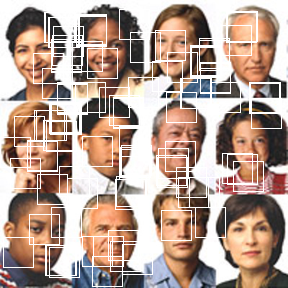

In [190]:
make_box(image_copy,face_positions)